In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

conn = sqlite3.connect('../data/nfp2/nfp2.db')  # Adjust the path to your database file

# Step 2 & 3: Query the database and load the data into a pandas DataFrame
query = "SELECT * FROM stellarators"  # Adjust your query as needed
data_df = pd.read_sql_query(query, conn)

data_df_clean = data_df[data_df['convergence'] == 1]
data_df_clean = data_df_clean.dropna(subset=['quasisymmetry'])


X = data_df_clean[['rbc_1_0', 'rbc_m1_1', 'rbc_0_1', 'rbc_1_1','zbs_1_0', 'zbs_m1_1', 'zbs_0_1', 'zbs_1_1']] 
Y = np.log(data_df_clean['quasisymmetry'])

features_no_outliers, test_features_no_outliers, target_no_outliers, test_target_no_outliers = train_test_split(X, Y, test_size=0.2, random_state=42)


from lightgbmlss.model import *
from lightgbmlss.distributions.Weibull import *
import lightgbm as lgb
import numpy as np



/home/rofarate/PIC-STELLARATOR/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


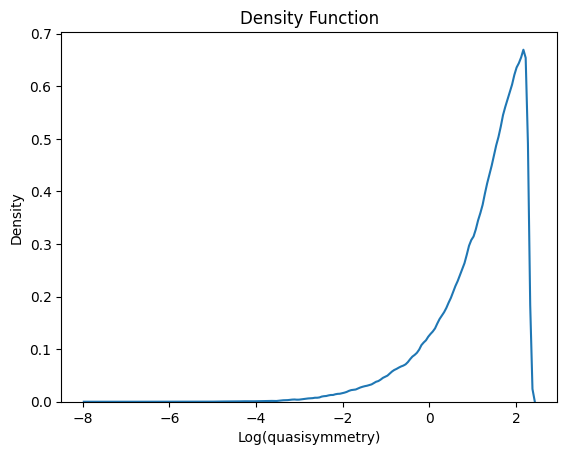

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.kdeplot(target_no_outliers, bw_adjust=0.5)
plt.title('Density Function')
plt.xlabel('Log(quasisymmetry)')
plt.ylabel('Density')
plt.show()


In [3]:
from sklearn.mixture import GaussianMixture

# from scipy.stats import norm



# # Assuming `Y_train_np` is your 1D numpy array data
# target_no_outliers_np = target_no_outliers.to_numpy().reshape(-1, 1)  # Reshape to 2D if necessary

# # Use AIC and BIC to determine the best number of components for GMM
# n_components_range = range(1, 10)  # Example range, can be adjusted
# lowest_bic = np.infty
# lowest_aic = np.infty
# best_gmm = None
# bic = []
# aic = []

# for n_components in n_components_range:
#     # Fit a Gaussian mixture with n components
#     gmm = GaussianMixture(n_components=n_components, random_state=0)
#     gmm.fit(target_no_outliers_np)
    
#     # Calculate the BIC and AIC
#     bic.append(gmm.bic(target_no_outliers_np))
#     aic.append(gmm.aic(target_no_outliers_np))
    
#     # Determine if this model has the lowest BIC
#     if bic[-1] < lowest_bic:
#         lowest_bic = bic[-1]
#         best_gmm_bic = gmm
        
#     # Determine if this model has the lowest AIC
#     if aic[-1] < lowest_aic:
#         lowest_aic = aic[-1]
#         best_gmm_aic = gmm

# # Plot the BIC scores
# plt.figure(figsize=(4, 2))
# plt.plot(n_components_range, bic, label='BIC')
# plt.plot(n_components_range, aic, label='AIC')
# plt.legend()
# plt.xlabel('Number of Components')
# plt.ylabel('Criterion Value')
# plt.title('BIC and AIC for GMM')
# plt.show()

# # Use the best model for the final density plot
# best_gmm = best_gmm_bic if lowest_bic < lowest_aic else best_gmm_aic
# print(f"Selected Model Components: {best_gmm.n_components}")

# # Generate some data points for plotting the density
# x = np.linspace(target_no_outliers_np.min(), target_no_outliers_np.max(), 1000).reshape(-1, 1)
# logprob = best_gmm.score_samples(x)
# responsibilities = best_gmm.predict_proba(x)
# pdf = np.exp(logprob)
# pdf_individual = responsibilities * pdf[:, np.newaxis]

# # Plot the actual kernel density estimation of your data
# sns.kdeplot(target_no_outliers_np.flatten(), bw_adjust=0.5, label='Actual')

# # Plot each component density
# for i in range(best_gmm.n_components):
#     plt.plot(x, pdf_individual[:, i], label=f'Gaussian {i+1}')

# # Plot the total density
# plt.plot(x, pdf, label='Mixture Total')

# plt.legend()
# plt.title('Actual data density vs. Gaussian Mixture Model density')
# plt.xlabel('Data values')
# plt.ylabel('Density')
# plt.show()


In [4]:
from lightgbmlss.distributions import Gaussian, StudentT, Gamma, Cauchy, LogNormal, Weibull, Gumbel, Laplace, Beta, Poisson, SplineFlow, NegativeBinomial
from lightgbmlss.distributions.distribution_utils import DistributionClass
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Your data preparation steps
target_no_outliers_np = np.array(target_no_outliers)

lgblss_dist_class = DistributionClass()
candidate_distributions = [Gaussian, StudentT, Gamma, Cauchy, LogNormal, Weibull, Gumbel, Laplace, Beta, Poisson, SplineFlow, NegativeBinomial]

# Selecting the best distribution based on negative log-likelihood
dist_nll = lgblss_dist_class.dist_select(target=target_no_outliers_np, candidate_distributions=candidate_distributions, max_iter=50, plot=True, figure_size=(8, 4))
dist_nll

# Plot the actual data density
plt.figure(figsize=(8, 4))
sns.kdeplot(target_no_outliers_np, bw_adjust=0.5, label='Actual Data Density')
plt.title('Density Function of Target Data')
plt.xlabel('Data')
plt.ylabel('Density')
plt.legend()
plt.show()


Fitting of candidate distributions completed: 100%|██████████| 8/8 [00:57<00:00,  7.15s/it]        


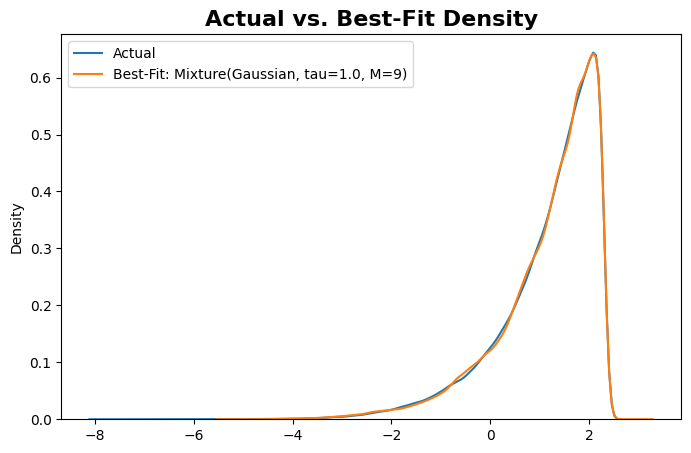

                nll                     distribution
rank                                                
1     212820.125000  Mixture(Gaussian, tau=1.0, M=9)
2     213187.906250  Mixture(Gaussian, tau=1.0, M=8)
3     213655.437500  Mixture(Gaussian, tau=1.0, M=7)
4     214555.015625  Mixture(Gaussian, tau=1.0, M=6)
5     215870.312500  Mixture(Gaussian, tau=1.0, M=5)
6     218385.171875  Mixture(Gaussian, tau=1.0, M=4)
7     223433.296875  Mixture(Gaussian, tau=1.0, M=3)
8     234355.640625  Mixture(Gaussian, tau=1.0, M=2)


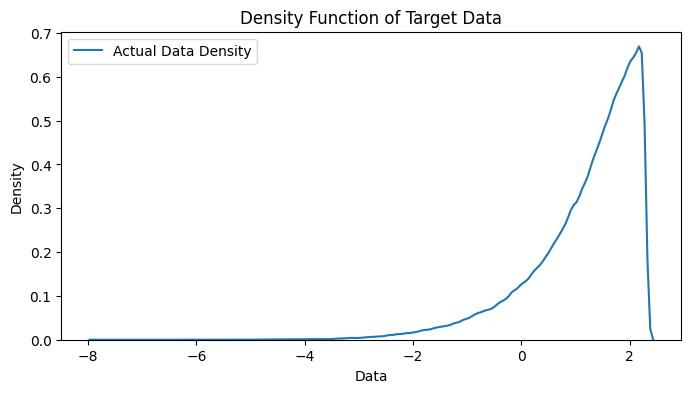

In [5]:
from lightgbmlss.model import *
from lightgbmlss.distributions.Gaussian import *
from lightgbmlss.distributions.Mixture import *
from lightgbmlss.distributions.mixture_distribution_utils import MixtureDistributionClass

from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
figure_size = (10,5)
import plotnine
from plotnine import *
plotnine.options.figure_size = figure_size


# # Initialize the MixtureDistributionClass
mix_dist_class = MixtureDistributionClass()

# # Define the candidate distributions
candidate_distributions = [
    Mixture(Gaussian(response_fn="softplus"), M=2),
    Mixture(Gaussian(response_fn="softplus"), M=3),
    Mixture(Gaussian(response_fn="softplus"), M=4),
    Mixture(Gaussian(response_fn="softplus"), M=5),
    Mixture(Gaussian(response_fn="softplus"), M=6),
    Mixture(Gaussian(response_fn="softplus"), M=7),
    Mixture(Gaussian(response_fn="softplus"), M=8),
    Mixture(Gaussian(response_fn="softplus"), M=9),
    #Mixture(Gaussian(response_fn="softplus"), M=10),
]

# Convert target to numpy array if not already
target_no_outliers_np = np.array(target_no_outliers)

# Selecting the best distribution based on negative log-likelihood
dist_nll = mix_dist_class.dist_select(target=target_no_outliers_np, candidate_distributions=candidate_distributions, max_iter=50, plot=True, figure_size=(8, 5))

# Output the negative log-likelihoods
print(dist_nll)

# Plot the actual data density
plt.figure(figsize=(8, 4))
sns.kdeplot(target_no_outliers_np, bw_adjust=0.5, label='Actual Data Density')
plt.title('Density Function of Target Data')
plt.xlabel('Data')
plt.ylabel('Density')
plt.legend()
plt.show()


este grafico apenas ve a distribuição da target variable?

In [6]:
from lightgbmlss.model import *
from lightgbmlss.distributions.Weibull import *
import lightgbm as lgb
import numpy as np
import signal

dtrain = lgb.Dataset(features_no_outliers, label=target_no_outliers.values, params={'max_bin': 3000})

# Initialize the LightGBMLSS model with the Mixture of Gaussians distribution
# Specifies a mixture of Gaussians. See ?Mixture for an overview.
lgblss = LightGBMLSS(
    Weibull(stabilization="None", response_fn="exp", loss_fn="nll")
)

# Define the parameter dictionary
param_dict = {
    "eta":                      ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":                ["int",   {"low": 1,      "high": 10,    "log": False}],
    "min_gain_to_split":        ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "min_sum_hessian_in_leaf":  ["float", {"low": 1e-8,   "high": 500,   "log": True}],
    "subsample":                ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "feature_fraction":         ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "boosting":                 ["categorical", ["gbdt", 'dart']],
}

# Set a seed for reproducibility
np.random.seed(123)

print('Debug: Before hyperparameter optimization')

np.random.seed(123)
opt_param = lgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=60,             # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=20,                # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=True,               # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )




Debug: Before hyperparameter optimization


  0%|          | 0/20 [00:00<?, ?it/s]

: 

In [ ]:
import numpy as np
import torch
from lightgbmlss.model import LightGBMLSS  # Ensure this import matches your actual usage

# Seed for reproducibility in numpy operations
np.random.seed(123)

# Assuming opt_param is defined somewhere in your code
opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Assuming dtrain is defined and is an appropriate dataset for training
# Train Model with optimized hyperparameters
lgblss.train(opt_params, dtrain, num_boost_round=n_rounds)

# Seed for reproducibility in torch operations
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = len(test_target_no_outliers)  # Use the number of rows in X_test as the number of samples

# Quantiles to calculate from predicted distribution
quant_sel = [0.05, 0.95]

# Sample from predicted distribution
pred_samples = lgblss.predict(
    X_test,
    pred_type="samples",
    n_samples=n_samples,
    seed=123
)

# Calculate quantiles from predicted distribution
pred_quantiles = lgblss.predict(
    X_test,
    pred_type="quantiles",
    n_samples=n_samples,
    quantiles=quant_sel
)

# Return predicted distributional parameters
pred_params = lgblss.predict(
    X_test,
    pred_type="parameters"
)


In [ ]:
df_predictions = pd.DataFrame({
    "Predicted": pred_samples.flatten(),  # Flatten in case the predictions are in a 2D array
    "Type": "Predicted"
})
df_actual = pd.DataFrame({
    "Predicted": np.tile(Y_test, (len(pred_samples) // len(Y_test))),
    "Type": "Actual"
})

# Combine and plot
df_combined = pd.concat([df_predictions, df_actual])
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_combined, x="Predicted", hue="Type", fill=True)
plt.title('Density Plot of Predicted Outputs vs Actual Values')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend(title='Type')
plt.show()

In [ ]:
pred_quantiles.head()

In [ ]:
pred_params.head()

In [ ]:
# Feature Importance of scale parameter
lgblss.plot(X_test,
            parameter="scale",
            plot_type="Feature_Importance")

In [ ]:

predicted_means = pred_params['concentration']
predicted_variances = pred_params['scale']

# Calculate standard deviation from variance
predicted_std = np.sqrt(predicted_variances)

# Calculate Mean Absolute Error (MAE) as one option for mean error
mean_error = np.mean(np.abs(predicted_means - Y_test))

# For Mean Squared Error (MSE), use:
# mean_squared_error = np.mean((predicted_means - Y_test) ** 2)

# Output the results
print(f"Mean Error (MAE): {mean_error}")
print(f"Standard Deviation: {predicted_std.mean()}")  # Average standard deviation across all predictions

# Note: The calculation of standard deviation's average might need adjustments based on your specific requirements.


In [ ]:
from plotnine import ggplot, aes, geom_point, geom_vline, stat_density, facet_wrap, labs, theme_bw, scale_fill_brewer, theme, element_text, element_blank

y_pred = []

n_examples = 9

for i in range(n_examples):    
    y_samples = pd.DataFrame(pred_samples.values[i,:].reshape(-1,1), columns=["PREDICT_DENSITY"])
    y_samples["PREDICT_POINT"] = y_samples["PREDICT_DENSITY"].mean()
    y_samples["PREDICT_Q05"] = y_samples["PREDICT_DENSITY"].quantile(q=quant_sel[0])
    y_samples["PREDICT_Q95"] = y_samples["PREDICT_DENSITY"].quantile(q=quant_sel[1])
    y_samples["ACTUAL"] = Y_test.iloc[i]
    y_samples["obs"]= f"Obervation {i+1}"
    y_pred.append(y_samples)
    
pred_df = pd.melt(pd.concat(y_pred, axis=0), id_vars="obs")
pred_df["obs"] = pd.Categorical(pred_df["obs"], categories=[f"Obervation {i+1}" for i in range(n_examples)])
df_actual, df_pred_dens, df_pred_point, df_q05, df_q95 = [x for _, x in pred_df.groupby("variable")]

plot_pred = (
    ggplot(pred_df,
           aes(color="variable")) + 
    stat_density(df_pred_dens,
                 aes(x="value"),
                 size=1.1) + 
    geom_point(df_pred_point,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_point(df_actual,
               aes(x="value",
                   y=0),
               size=1.4) + 
    geom_vline(df_q05, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    geom_vline(df_q95, 
               aes(xintercept="value",
                   fill="variable",
                   color="variable"),
               linetype="dashed",
               size=1.1) + 
    facet_wrap("obs",
               scales="free",
               ncol=3) + 
    labs(title="Predicted vs. Actual \n",
         x = "") + 
    theme_bw(base_size=15) +
    scale_fill_brewer(type="qual", palette="Dark2") + 
    theme(legend_position="bottom",
          plot_title = element_text(hjust = 0.5),
          legend_title = element_blank()
         )
)

print(plot_pred)

UMAP WITH FEATURES AND MEAN ERROR

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import umap

# Calculate the absolute error for each prediction
absolute_errors = np.abs(predicted_means - Y_test)

# Combine the features and the errors into one DataFrame for t-SNE/UMAP
tsne_features = X_test.copy()
tsne_features['absolute_error'] = absolute_errors

# Replace inf/-inf with NaN
tsne_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Option 1: Drop rows with NaNs (if they were inf/-inf)
tsne_features.dropna(inplace=True)


# Initialize UMAP. You can adjust n_neighbors and min_dist as needed.
reducer = umap.UMAP(n_neighbors=200, min_dist=1, n_components=2, random_state=42)

# Fit and transform the features (excluding the 'absolute_error' column)
embedding = reducer.fit_transform(tsne_features.drop('absolute_error', axis=1))

# Now, let's create the plot using UMAP results
plt.figure(figsize=(10,6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=tsne_features['absolute_error'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Mean Absolute Error')
plt.title('UMAP plot with points colored by prediction error')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()


UMAP WITH FEATURES AND STD

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Replace inf/-inf with NaN in your features
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Check if there are any NaN values and handle them
if X_test.isnull().values.any():
    # Impute the NaNs or drop the rows/columns with NaN values.
    # Here we impute with the mean, but you might want to consider other imputation methods
    X_test = X_test.fillna(X_test.mean())

# Ensure no infinite values in predicted_variances before calculating the standard deviation
predicted_variances = np.where(np.isfinite(predicted_variances), predicted_variances, np.nan)
predicted_variances = np.nan_to_num(predicted_variances, nan=np.nanmean(predicted_variances))
predicted_std = np.sqrt(predicted_variances)

# Normalize your features to ensure they don't contain too large values
scaler = MinMaxScaler()
X_test_scaled = scaler.fit_transform(X_test)

# Combine the scaled features and the standard deviations into one DataFrame for UMAP
umap_features = pd.DataFrame(X_test_scaled, columns=X_test.columns)
umap_features['std_dev'] = predicted_std

# Initialize UMAP. You can adjust n_neighbors and min_dist as needed.
reducer = umap.UMAP(n_neighbors=200, min_dist=1, n_components=2, random_state=42)

# Fit and transform the features (excluding the 'std_dev' column)
embedding = reducer.fit_transform(umap_features.drop('std_dev', axis=1))

# Now, let's create the plot using UMAP results
plt.figure(figsize=(12,8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=umap_features['std_dev'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Standard Deviation')
plt.title('UMAP plot with points colored by standard deviation')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()


UMAP WITH TARGET AND MEAN ERROR

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import umap

# Calculate the absolute error for each prediction
absolute_errors = np.abs(predicted_means - Y_test)
f_t = pd.concat([X_test, Y_test], axis=1)

# Combine the features and the errors into one DataFrame for t-SNE/UMAP
tsne_features = f_t.copy()
tsne_features['absolute_error'] = absolute_errors

# Replace inf/-inf with NaN
tsne_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Option 1: Drop rows with NaNs (if they were inf/-inf)
tsne_features.dropna(inplace=True)


# Initialize UMAP. You can adjust n_neighbors and min_dist as needed.
reducer = umap.UMAP(n_neighbors=200, min_dist=1, n_components=2, random_state=42)

# Fit and transform the features (excluding the 'absolute_error' column)
embedding = reducer.fit_transform(tsne_features.drop('absolute_error', axis=1))

# Now, let's create the plot using UMAP results
plt.figure(figsize=(10,6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=tsne_features['absolute_error'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Mean Absolute Error')
plt.title('UMAP plot with points colored by prediction error')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()


UMAP WITH TARGET AND STD

In [ ]:
# Assuming `X_test` and `Y_test` are pandas DataFrames and `predicted_variances` is a numpy array

# Replace inf/-inf with NaN and then drop or impute NaN values for both X_test and Y_test
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
Y_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Assuming you want to impute NaN values, do it for both
X_test = X_test.fillna(X_test.mean())
Y_test = Y_test.fillna(Y_test.mean())

# Combine X_test and Y_test into a single DataFrame
combined_data = pd.concat([X_test, Y_test], axis=1)

# Normalize your features to ensure they don't contain too large values
scaler = MinMaxScaler()
combined_data_scaled = scaler.fit_transform(combined_data)

# Combine the scaled features into one DataFrame for UMAP
umap_features = pd.DataFrame(combined_data_scaled, columns=combined_data.columns)

# Initialize UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# Fit and transform the features
embedding = reducer.fit_transform(umap_features)

# Ensure no infinite values in predicted_variances before calculating the standard deviation
predicted_variances = np.where(np.isfinite(predicted_variances), predicted_variances, np.nan)
predicted_variances = np.nan_to_num(predicted_variances, nan=np.nanmean(predicted_variances))
predicted_std = np.sqrt(predicted_variances)

# Add standard deviation to the UMAP features for coloring the plot
umap_features['std_dev'] = predicted_std

# Now, let's create the plot using UMAP results
plt.figure(figsize=(12,8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],
                      c=umap_features['std_dev'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Standard Deviation')
plt.title('UMAP plot with points colored by standard deviation')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.show()
